# This notebook computes predictions for lensing of dwarf galaxies for various upcoming lensing surveys.

In [1]:
#import camb
#pars = camb.CAMBparams()
from scipy.special import jn, jn_zeros
#from camb import model, initialpower
from scipy.interpolate import interp1d
from hankel_transform import *
from power_spectra import *
from astropy.cosmology import Planck15 as cosmo #use Planck15 if you can
import astropy.units as u
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams["font.family"] = "serif"
from scipy.signal import savgol_filter
import scipy.integrate as integrate

plt.rcParams['text.usetex'] = False
#rc('text', usetex=False)
cosmo_h=cosmo.clone(H0=70)

In [2]:
# Option: use shape noise only (shapenoiseonly=1), or all sources of noise
shapenoiseonly = 0

In [3]:
# Read in the COSMOS GALAXY SMF
SMF_prof=np.genfromtxt('./cosmos2015_dic2017_smf_z01-04_STY0.txt',names=('log_m','log_phi','log_phi_inf','log_phi_sup'))
log_m=SMF_prof['log_m']
log_phi=SMF_prof['log_phi']

## Survey and Lens Sample Parameters

In [55]:
# COSMOS Survey
z_source=np.atleast_1d([1.2])   # mean redshift of sources
sigma_gamma=0.28
n_s_arcmin=39.0 #n sources per arcmin^2
area=1.64 #in deg^-2

z_lens_min=0.0
z_lens_max=0.25
z_lens_mean =0.18 # Got this value from data

# Range of lens M*
Ms_min = 8
Ms_max = 9

resultfile='cosmos_8_9_0_0.25.txt'
headernote='This is the DS profile with errors for COSMOS Survey\nRP DS DS_error'

# Corresponding DS file from Felipe
DS_prof=np.genfromtxt('./BolPlanck_r_DS_50.txt',names=('rp','DS'))

In [57]:
# HSC wide
z_source=np.atleast_1d([0.81])   # mean redshift of sources
sigma_gamma=0.28
n_s_arcmin=18.5 #n sources per arcmin^2
area=1000.0 #in deg^-2

z_lens_min=0.0
z_lens_max=0.25
z_lens_mean =0.18 # Got this value from data

# Range of lens M*
Ms_min = 8
Ms_max = 9

resultfile='hscwide_8_9_0_0.25.txt'
headernote='This is the DS profile with errors for HSC wide\nRP DS DS_error'

# Corresponding DS file from Felipe
DS_prof=np.genfromtxt('./BolPlanck_r_DS_50.txt',names=('rp','DS'))

In [84]:
# LSST wide
z_source=np.atleast_1d([1.2])   # mean redshift of sources
sigma_gamma=0.28
n_s_arcmin=30.0 #n sources per arcmin^2
area=18000.0 #in deg^-2

z_lens_min=0.0
z_lens_max=0.25
z_lens_mean =0.18 # Got this value from data

# Range of lens M*
Ms_min = 8
Ms_max = 9

resultfile='lsstwide_8_9_0_0.25.txt'
headernote='This is the DS profile with errors for LSST wide\nRP DS DS_error'

# Corresponding DS file from Felipe
DS_prof=np.genfromtxt('./BolPlanck_r_DS_50.txt',names=('rp','DS'))

In [111]:
# Euclid wide
z_source=np.atleast_1d([1.2])   # mean redshift of sources
sigma_gamma=0.28
n_s_arcmin=30.0 #n sources per arcmin^2
area=15000.0 #in deg^-2

z_lens_min=0.0
z_lens_max=0.25
z_lens_mean =0.18 # Got this value from data

# Range of lens M*
Ms_min = 8
Ms_max = 9

resultfile='euclid_8_9_0_0.25.txt'
headernote='This is the DS profile with errors for Euclid wide\nRP DS DS_error'

# Corresponding DS file from Felipe
DS_prof=np.genfromtxt('./BolPlanck_r_DS_50.txt',names=('rp','DS'))

In [138]:
# WFIRSTHLS
z_source=np.atleast_1d([1.1])   # mean redshift of sources
sigma_gamma=0.28
n_s_arcmin=45.0 #n sources per arcmin^2
area=2400.0 #in deg^-2

z_lens_min=0.0
z_lens_max=0.25
z_lens_mean =0.18 # Got this value from data

# Range of lens M*
Ms_min = 8
Ms_max = 9

resultfile='wfirst_8_9_0_0.25.txt'
headernote='This is the DS profile with errors for WFIRSTHLS\nRP DS DS_error'

# Corresponding DS file from Felipe
DS_prof=np.genfromtxt('./BolPlanck_r_DS_50.txt',names=('rp','DS'))

In [139]:
z_lens=np.atleast_1d([z_lens_mean])

In [140]:
# Get the number density of lenses by integrating the SMF
# and shot noise

SMF = interp1d(log_m, log_phi, kind=3)
x_SMF = np.linspace(0,13,10000)
Phi_interp1d = SMF(x_SMF)
SMF_new = interp1d(x_SMF, pow(10,Phi_interp1d), kind=3)
phiintegral = integrate.quad(lambda x: SMF_new(x), Ms_min, Ms_max)[0]
n_g = phiintegral
g_shot_noise=1./n_g

In [141]:
# Set up the R binning in DS
dlogr=np.gradient(np.log10(DS_prof['rp']))[0]
rmin=0.01 #10**(np.log10(DS_prof['rp'][0])-dlogr/2)
rmax=20 #10**(np.log10(DS_prof['rp'][-1])+dlogr/2)
nbins=len(DS_prof['rp'])

rp_bins=np.logspace(np.log10(rmin),np.log10(rmax),nbins+1)

In [142]:
#Set up a new set of parameters for power spectra and correlation functions
PS=Power_Spectra()
PS.pk_params['kmax']=520
PS.pk_params['kmin']=1e-2
PS.pk_params['non_linear']=1
rmin=.01
rmax=20

In [143]:
cosmo_params=dict({'h':cosmo.h,'Omb':cosmo.Ob0,'Omd':cosmo.Odm0,'Om':cosmo.Om0,
                'As':2.14e-09,'mnu':cosmo.m_nu[-1].value,'Omk':cosmo.Ok0,'tau':0.06,'ns':0.965,
                  'w':-1,'wa':0})

In [144]:
pk,kh=PS.class_pk(z_lens,cosmo_params=cosmo_params,pk_params=pk_params,return_s8=False)
h=cosmo.h
k=kh*h
pk=pk/h**3
rho=PS.Rho_crit(cosmo=cosmo)*cosmo.Om0

In [145]:
#Setting up the Hankel Transform
#This deals with the interpolation over the Bessel Functions
#This part is slower. But only needs to be run once. 
#If you only need wgg, set j_nu=[0]. For wg+ (or \Delta\Sigma) use j_nu=[2]
%time HT=hankel_transform(rmin=rmin,rmax=rmax,kmax=PS.pk_params['kmax'],j_nu=[2],n_zeros=80000,kmin=PS.pk_params['kmin'],prune_r=0)
%time HT_inv=hankel_transform(rmin=PS.pk_params['kmin'],rmax=PS.pk_params['kmax'],kmax=rmax,j_nu=[2],n_zeros=80000,kmin=rmin,prune_r=50)
#HT=hankel_transform(rmin=1,rmax=rmax,kmax=1,j_nu=[0,2],n_zeros=2800,kmin=1.e-2)#quick test... inaccurate

j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 81000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 82000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 83000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 84000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 85000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 86000
nr: 3310
CPU times: user 1min 20s, sys: 1.81 s, total: 1min 21s
Wall time: 1min 23s
changed kmax to 513.5622301840683  to cover rmin
j-nu= 2  not enough zeros to cover rmax, increasing by  1000  to 81000
j-nu= 2  not enough zeros to cover rmax, increasing by  1000  to 82000
j-nu= 2  not enough zeros to cover rmax, increasing by  1000  to 83000
j-nu= 2  not enough zeros to cover rmax, increasing by  1000  to 84000
j-nu= 2  not enough zeros to cover rmax, increasing by  1000  to 85000
j-nu= 2  not enough zeros to cover rmax, increasing by  1000  to 86000
pruning r, log_

In [146]:
x=HT_inv.k[2]>DS_prof['rp'].max()
DS2=DS_prof['DS'][-1]*DS_prof['rp'][-1]/HT_inv.k[2][x]
DS2=np.append(DS_prof['DS'],DS2)
rp2=np.append(DS_prof['rp'],HT_inv.k[2][x]) #this doesnot help
#DS2 = savgol_filter(DS2, 5, 3) # window size 51, polynomial order 3

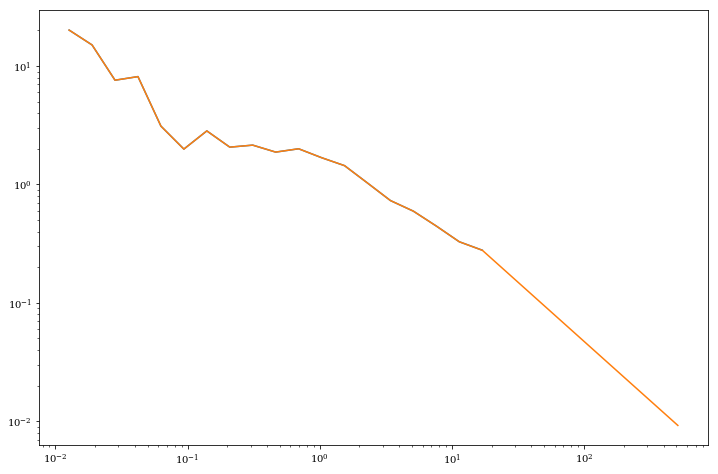

In [147]:
plt.plot(DS_prof['rp'],DS_prof['DS'])
plt.plot(rp2,DS2)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [148]:
k2,p_gk2=HT_inv.projected_correlation(k_pk=rp2,pk=DS2,j_nu=2)
p_gk2*=(2*np.pi)**2 #factors due to fourier convention
# p_gk2*=(HT.kmax[2]**2/HT.rmax[2]**2) #https://www.gnu.org/software/gsl/doc/html/dht.html
#p_gk2 = savgol_filter(p_gk2, 21, 3) # window size 51, polynomial order 3

In [149]:
# This is just for the clustering term
# In the future could do more sophisticated model for bias of clustering
# by measuring the clustering in the simulation
# Could do a b1 and b2 term
# shouldnt have a large impact on the errors though
b_g=1
p_g=b_g**2*pk[0]
p_gk=b_g*pk[0]*rho

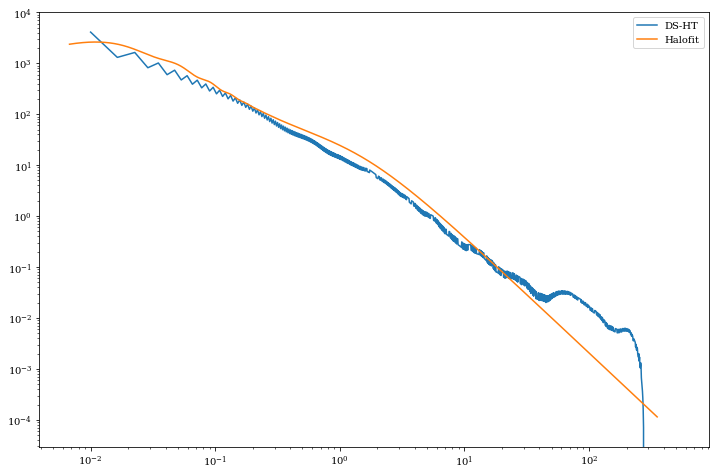

In [150]:
plt.loglog(k2,p_gk2,label='DS-HT') #sim profile, extrapolated and then inv-HT
plt.loglog(k,p_gk,label='Halofit')
plt.legend()
plt.show()

In [151]:
r_th,DS_th2=HT.projected_correlation(k_pk=k2,pk=p_gk2,j_nu=2)
r_th,DS_th=HT.projected_correlation(k_pk=k,pk=p_gk,j_nu=2)

In [152]:
rp,DS_th_b=HT.bin_mat(r=r_th,r_bins=rp_bins,mat=DS_th) #bin the theory predictions
rp,DS_th_b2=HT.bin_mat(r=r_th,r_bins=rp_bins,mat=DS_th2) #bin the theory predictions

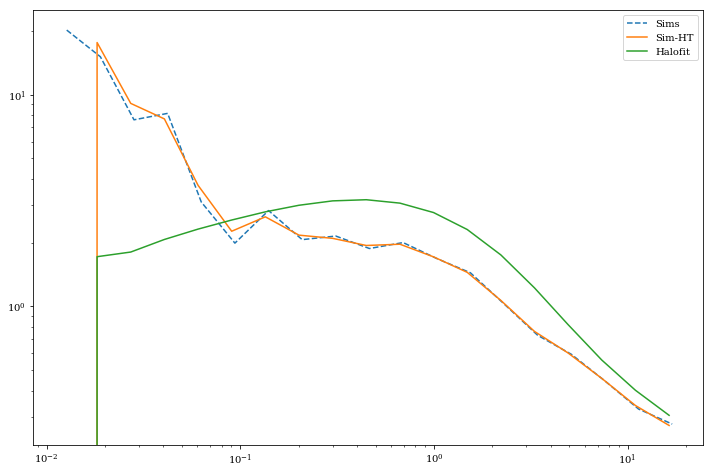

In [153]:
plt.plot(DS_prof['rp'],DS_prof['DS'],'--',label='Sims')
plt.plot(rp,DS_th_b2,label='Sim-HT') # Extrapolatred profile from sims, inv-HT to get power spectra and then HT back
plt.plot(rp,DS_th_b,label='Halofit')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# g-g Lensing covariance

We are using the real-space DS(r_p) covariance expression from Sukhdeep Singh's paper, Eq 10.
http://adsabs.harvard.edu/abs/2016arXiv161100752S

Here we are using the part withuot the curly brackets (as explained later in the text, if you subtract DS around randoms to get the optimal estimator, you get rid of the curly brackets term)

We are ignoring the connected $T_{g \gamma g \gamma}$ term, as it’s unlikely to be very important and is so much harder to calculate, and we are just keeping the $(P_{gg} + N_g) (P_{\gamma \gamma} + N_\gamma) + P_{g \gamma}^2$ stuff, so you have lens clustering and shot noise, cosmic shear and shape noise, and cosmic variance terms.

In [154]:
# This is the comoving distance between zlens_min and zlens_max
# line of sight window lenght
# redshift bins lens Mpc
L_W=cosmo.angular_diameter_distance(z_lens_max)-cosmo.angular_diameter_distance(z_lens_min)
L_W=L_W.value

area_comoving=area*(np.pi/180)**2*cosmo.angular_diameter_distance(z_lens_mean)**2

In [155]:
#check H0 and comoving physical
sigma_crit=PS.sigma_crit(zl=z_lens,zs=z_source,cosmo=cosmo)
sigma_crit=sigma_crit[0,0].value

In [156]:
d2r=np.pi/180.
n_s=n_s_arcmin*3600/d2r**2
shape_noise=sigma_gamma**2/n_s

In [157]:
l,cl_kappa_kappa=PS.kappa_cl(zs1=z_source,p_zs1=[1],zs2=z_source,p_zs2=[1],zl_max=z_source,n_zl=100,
                             l=np.arange(5.e5),cosmo=cosmo)
chi=cosmo.angular_diameter_distance(z_lens)
k_l=(l+0.5)/chi
cl_intp=interp1d(k_l,cl_kappa_kappa,bounds_error=False,fill_value=0)

# approximation of convergence power spectrum p_kappa_kappa
# integration over LOS window function

# YIFEI CHECK HERE!!!
# Comment out here to change
if shapenoiseonly == 1:
    p_kappa_kappa=sigma_crit**2*(cl_intp(k)*0+shape_noise)*chi**2 #shape noise only    
else:
    p_kappa_kappa=sigma_crit**2*(cl_intp(k)+shape_noise)*chi**2  #all noise


/Users/yifei/work/dwarf/Predicting lensing for dwarfs/sukhdeep/Predicting lensing for dwarfs/sukhdeep/Alexie_dwarfs/power_spectra.py:231: RuntimeWarning: divide by zero encountered in true_divide
  pk_int=interp1d(lz,pk[i]/DC_i**2,bounds_error=False,fill_value=0)
/Users/yifei/anaconda/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/yifei/work/dwarf/Predicting lensing for dwarfs/sukhdeep/Predicting lensing for dwarfs/sukhdeep/Alexie_dwarfs/power_spectra.py:257: RuntimeWarning: divide by zero encountered in true_divide
  f=(l+0.5)**2/(l*(l+1.)) #correction from Kilbinger+ 2017


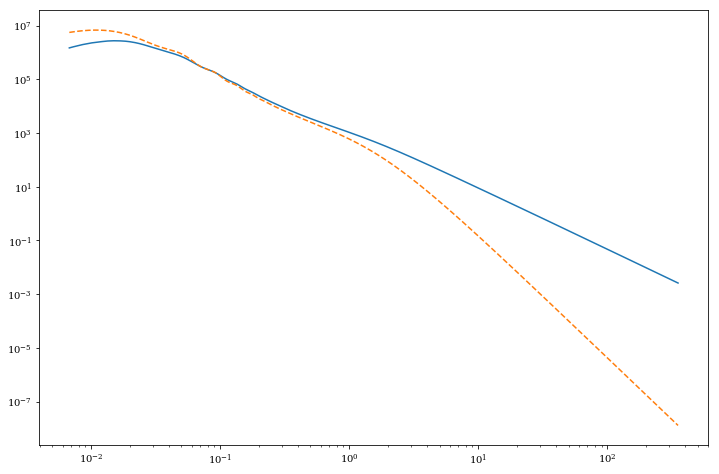

In [158]:
plt.plot(k,p_kappa_kappa*p_g/L_W)
plt.plot(k,p_gk**2,'--')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [159]:
taper_kw=dict({'large_k_lower':500,'large_k_upper':PS.pk_params['kmax'],'low_k_lower':PS.pk_params['kmin'],
               'low_k_upper':PS.pk_params['kmin']*1.2})

In [160]:
# Pgg x Pgammagamma

if shapenoiseonly == 1:
    r,cov_ggkk=HT.projected_covariance(k_pk=k,pk1=p_g*0+g_shot_noise,pk2=p_kappa_kappa,j_nu=2,taper=True,**taper_kw) #shape noise only
else:
    r,cov_ggkk=HT.projected_covariance(k_pk=k,pk1=p_g+g_shot_noise,pk2=p_kappa_kappa,j_nu=2,taper=True,**taper_kw) #all noise


r_re,cov_ggkk_re=HT.bin_cov(r=r,cov=cov_ggkk,r_bins=rp_bins)
corr=HT.corr_matrix(cov=cov_ggkk_re)

/Users/yifei/work/dwarf/Predicting lensing for dwarfs/sukhdeep/Predicting lensing for dwarfs/sukhdeep/Alexie_dwarfs/hankel_transform.py:138: RuntimeWarning: invalid value encountered in double_scalars
  corr[i][j]=cov[i][j]/np.sqrt(cov[i][i]*cov[j][j])


In [161]:
#### ***** YIFEI CHECK HERE

r,cov_gkgk=HT.projected_covariance(k_pk=k,pk1=p_gk,pk2=p_gk,j_nu=2,taper=True,**taper_kw)#return_Jrr=True,Jrr=Jrr
#Donot use gkgk when doing noise only
r_re,cov_gkgk_re=HT.bin_cov(r=r,cov=cov_gkgk,r_bins=rp_bins)
corr=HT.corr_matrix(cov=cov_gkgk_re)

/Users/yifei/work/dwarf/Predicting lensing for dwarfs/sukhdeep/Predicting lensing for dwarfs/sukhdeep/Alexie_dwarfs/hankel_transform.py:138: RuntimeWarning: invalid value encountered in double_scalars
  corr[i][j]=cov[i][j]/np.sqrt(cov[i][i]*cov[j][j])


In [162]:
# Pgg x Pgammagamma

cov_ggkk_re/=(area_comoving.value*L_W)
cov_gkgk_re/=area_comoving.value

if shapenoiseonly == 1:
     cov_final=cov_ggkk_re #shape noise only    
else:
    cov_final=(cov_ggkk_re+cov_gkgk_re)#/area_comoving.value #all noise

corr=HT.corr_matrix(cov=cov_final)
errors=HT.diagonal_err(cov=cov_final)
errors_ggkk=HT.diagonal_err(cov=cov_ggkk_re)
errors_gkgk=HT.diagonal_err(cov=cov_gkgk_re)

/Users/yifei/work/dwarf/Predicting lensing for dwarfs/sukhdeep/Predicting lensing for dwarfs/sukhdeep/Alexie_dwarfs/hankel_transform.py:138: RuntimeWarning: invalid value encountered in double_scalars
  corr[i][j]=cov[i][j]/np.sqrt(cov[i][i]*cov[j][j])


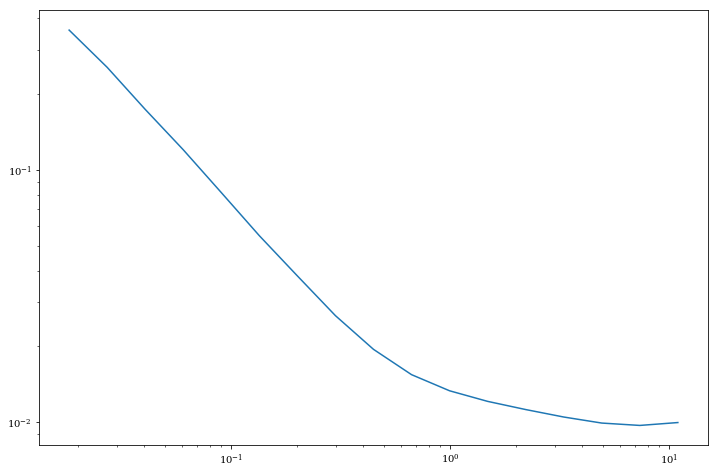

In [163]:
# Plot DS with errors here
plt.plot(r_re[1:18],errors_ggkk[1:18])
plt.xscale("log")
plt.yscale("log")
plt.show()

In [164]:
# Save the results in a file
# save resultfile here
result = np.array([DS_prof['rp'][1:18],DS_prof['DS'][1:18],errors_ggkk[1:18]])
result = result.T
np.savetxt(resultfile,result,fmt='%.7f',delimiter=' ',newline='\n',header=headernote,footer='')